# Использование предварительно обученной CNN

## Используемые библиотеки

In [11]:
import keras
import shutil, os
from keras.applications.vgg16 import VGG16
import numpy as np
from keras import layers
from keras import Sequential
from keras import optimizers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

2023-01-29 12:45:02.946204: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2023-01-29 12:45:02.946244: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-29 12:45:02.946268: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s-fca14154-d790-457e-b5bf-0f3f0c246cb3): /proc/driver/nvidia/version does not exist
2023-01-29 12:45:02.946474: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Константы

In [12]:
BATCH_SIZE = 20
TRAIN_PATH = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', 'train')
TEST_PATH = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', 'test')
VAL_PATH = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn', 'val')

## Экземпляр сверточной основы VGG16

In [13]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Пути использования готовой сверточной основы

- Менее энергозатратный: Преобразовать датасет при помощи готовой сверточной основы и обучить простую полносвязную сеть
- Более энергозатратный: Поверх сверточной сети добавить полносвязный классификатор

## Путь 0. Менее энергозатратный

### Формируем фичи

In [38]:
#!g2.mig

def extract_features(directory: str, sample_count: int):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # Последние 3 значения соответсвуют форме выходу сверточной основы
    labels = np.zeros(shape=(sample_count))
    
    conv_base = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )
    
    datagen = ImageDataGenerator(rescale=1/255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        
        features[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = features_batch
        labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = labels_batch
        
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    
    return features, labels

In [39]:
#!g2.mig

train_features, train_labels = extract_features(TRAIN_PATH, 2000)
val_features, val_labels = extract_features(VAL_PATH, 1000)
test_features, test_labels = extract_features(TEST_PATH, 1000)

2023-01-29 13:12:19.279000: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 13:12:19.753070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2629 MB memory:  -> device: 0, name: GRID A100X-1-5C MIG 1g.5gb, pci bus id: 0000:8c:00.0, compute capability: 8.0
2023-01-29 13:12:20.976937: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-29 13:12:21.658213: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-01-29 13:12:23.523769: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [40]:
#!g2.mig

train_features = train_features.reshape(2_000, 4 * 4 * 512)
val_features = val_features.reshape(1_000, 4 * 4 * 512)
test_features = test_features.reshape(1_000, 4 * 4 * 512)

### Создаем классификтор

In [41]:
#!g2.mig

model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(8192,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [42]:
#!g2.mig
history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    validation_data=(val_features, val_labels)
)

2023-01-29 13:12:58.366940: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Epoch 1/30
63/63 [==============================] - 1s 6ms/step - loss: 0.8781 - acc: 0.7210 - val_loss: 0.9687 - val_acc: 0.6510
Epoch 2/30
63/63 [==============================] - 0s 4ms/step - loss: 0.3982 - acc: 0.8235 - val_loss: 0.2816 - val_acc: 0.8750
Epoch 3/30
63/63 [==============================] - 0s 4ms/step - loss: 0.3113 - acc: 0.8715 - val_loss: 0.2767 - val_acc: 0.8800
Epoch 4/30
63/63 [==============================] - 0s 4ms/step - loss: 0.2828 - acc: 0.8865 - val_loss: 0.4525 - val_acc: 0.8290
Epoch 5/30
63/63 [==============================] - 0s 4ms/step - loss: 0.2400 - acc: 0.9035 - val_loss: 0.3260 - val_acc: 0.8660
Epoch 6/30
63/63 [==============================] - 0s 4ms/step - loss: 0.2207 - acc: 0.9045 - val_loss: 0.3790 - val_acc: 0.8580
Epoch 7/30
63/63 [==============================] - 0s 4ms/step - loss: 0.1900 - acc: 0.9220 - val_loss: 0.3262 - val_acc: 0.8850
Epoch 8/30
63/63 [==============================] - 0s 4ms/step - loss: 0.1573 - acc: 0.94

In [43]:
history_dict = history.history

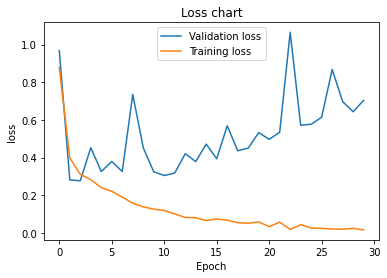

In [44]:
epochs = range(len(history_dict['val_loss']))

fig, ax = plt.subplots()

ax.plot(epochs, history_dict['val_loss'], label='Validation loss')
ax.plot(epochs, history_dict['loss'], label='Training loss')
ax.set(xlabel='Epoch', ylabel='loss', title='Loss chart')

plt.legend()
plt.show()

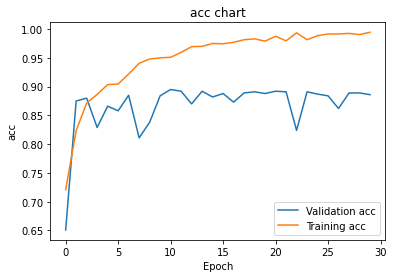

In [45]:
epochs = range(len(history_dict['val_acc']))

fig, ax = plt.subplots()

ax.plot(epochs, history_dict['val_acc'], label='Validation acc')
ax.plot(epochs, history_dict['acc'], label='Training acc')
ax.set(xlabel='Epoch', ylabel='acc', title='acc chart')

plt.legend()
plt.show()

### Выводы

Заметно значительное повышение качества модели
- Точность повысилась до 0.9
- Потери около 0.8

Заметен эффект переобучения на первых эпохах. Модели не хвататет данных

## Путь 1. Энергозатраный

In [62]:
#!g2.mig
train_data = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_data = ImageDataGenerator(rescale=1/255)

In [63]:
#!g2.mig
train_generator = train_data.flow_from_directory(
    TRAIN_PATH,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
valid_generator = train_data.flow_from_directory(
    VAL_PATH,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = test_data.flow_from_directory(
    TEST_PATH,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [64]:
#!g2.mig

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [65]:
#!g2.mig

model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_shape=(8192,)))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [66]:
#!g2.mig

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [68]:
#!g2.mig

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=50
)

2023-01-29 18:42:44.426152: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-29 18:42:47.648000: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2023-01-29 18:42:55.257767: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-29 18:42:55.257839: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-01-29 18:42:56.200755: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

100/100 [==============================] - 35s 213ms/step - loss: 0.7636 - acc: 0.6845 - val_loss: 0.5379 - val_acc: 0.7210
Epoch 2/30
100/100 [==============================] - 16s 158ms/step - loss: 0.4954 - acc: 0.7555 - val_loss: 0.7694 - val_acc: 0.6340
Epoch 3/30
100/100 [==============================] - 14s 144ms/step - loss: 0.4414 - acc: 0.7865 - val_loss: 0.5682 - val_acc: 0.7060
Epoch 4/30
100/100 [==============================] - 14s 144ms/step - loss: 0.4153 - acc: 0.8085 - val_loss: 0.4023 - val_acc: 0.8120
Epoch 5/30
100/100 [==============================] - 14s 145ms/step - loss: 0.3754 - acc: 0.8325 - val_loss: 0.3697 - val_acc: 0.8330
Epoch 6/30
100/100 [==============================] - 14s 144ms/step - loss: 0.3972 - acc: 0.8125 - val_loss: 0.4441 - val_acc: 0.7760
Epoch 7/30
100/100 [==============================] - 14s 143ms/step - loss: 0.3888 - acc: 0.8325 - val_loss: 0.3643 - val_acc: 0.8350
Epoch 8/30
100/100 [==============================] - 14s 144ms/st

In [69]:
history_dict = history.history

2023-01-29 18:51:23.648016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64
2023-01-29 18:51:23.648058: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-29 18:51:23.648078: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s-fdd4d8bf-b259-460b-a616-9593f9caa131): /proc/driver/nvidia/version does not exist
2023-01-29 18:51:23.648368: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

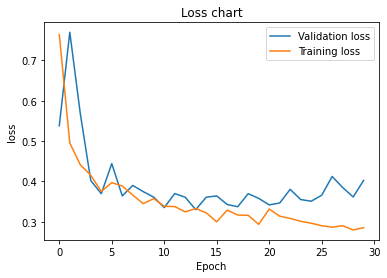

In [70]:
epochs = range(len(history_dict['val_loss']))

fig, ax = plt.subplots()

ax.plot(epochs, history_dict['val_loss'], label='Validation loss')
ax.plot(epochs, history_dict['loss'], label='Training loss')
ax.set(xlabel='Epoch', ylabel='loss', title='Loss chart')

plt.legend()
plt.show()

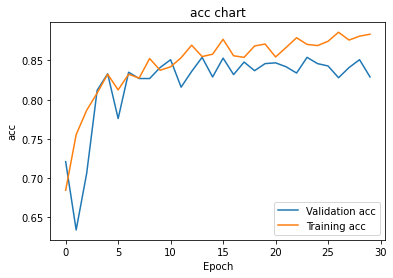

In [71]:
epochs = range(len(history_dict['val_acc']))

fig, ax = plt.subplots()

ax.plot(epochs, history_dict['val_acc'], label='Validation acc')
ax.plot(epochs, history_dict['acc'], label='Training acc')
ax.set(xlabel='Epoch', ylabel='acc', title='acc chart')

plt.legend()
plt.show()

### Выводы

Заметно значительное повышение качества модели
- Точность немного уменьшилась по сравнению с предыдущей моделей
- Потери упали примерно до 0.4

Эффект переобучения выявлен не так выражено